<a href="https://colab.research.google.com/github/ghgh415263/Mal_dectection/blob/main/ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/data/malimg_dataset.zip" -d "/content/dataset"

Found 9339 files belonging to 25 classes.
Using 1867 files for validation.


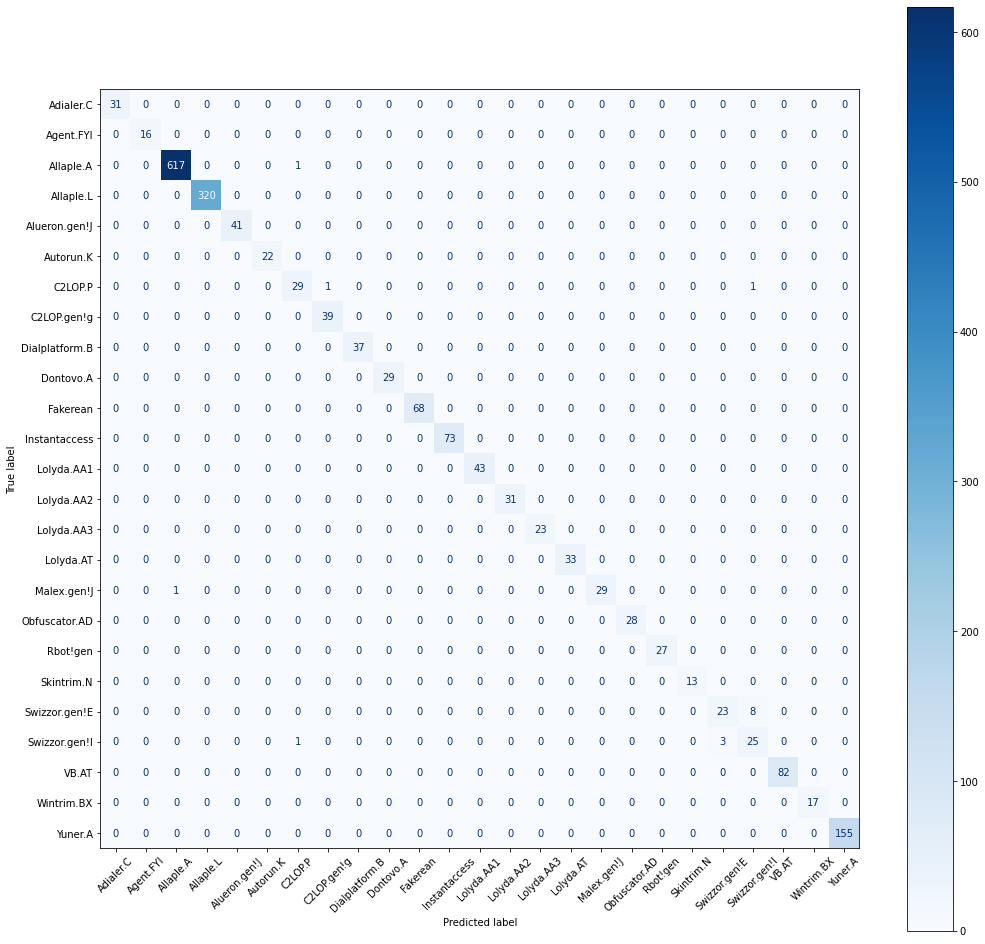

In [3]:
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.vgg16 import VGG16

import pathlib

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

DATA_PATH = "/content/dataset"
batch_size = 64
img_height = 224
img_width = 224

data_dir = pathlib.Path(DATA_PATH)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  color_mode='rgb',
  interpolation='bicubic',
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

base_model = VGG16(include_top=False, input_shape=(img_height,img_width,3))
base_model2 = VGG16(include_top=False, input_shape=(img_height,img_width,3))

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    base_model,
    keras.layers.Dropout(0.1),
    layers.MaxPooling2D(pool_size=(2, 2), padding="valid"),
    layers.Flatten(),
    layers.Dense(25, activation='softmax')
])

model2 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    base_model2,
    layers.Flatten(),
    layers.Dense(25, activation='softmax')
])

model2.load_weights("/content/drive/MyDrive/Colab_Notebooks/save/vgg16(25)-batch32-0.001/cp-0040.ckpt")
model.load_weights("/content/drive/MyDrive/Colab_Notebooks/save/vgg16(maxpool)-drop0.1-batch128-0.001/cp-0140.ckpt")

#평가를 위한 코드
y_test = np.array([])
y_pred = np.array([])

for x,y in val_ds:
  y_test = np.append(y_test, y.numpy(), axis=0)
  tmp = (model.predict(x)+model2.predict(x)).argmax(axis=-1)
  y_pred = np.append(y_pred, tmp, axis=0)

cm = confusion_matrix(y_test, y_pred) # normalize='true'

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_ds.class_names)
fig, ax = plt.subplots(figsize=(17,17))

disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
plt.show()